### FIG.3 plot for examples in 3_attention/2A_save_meme.py and 2A_TEST.ipynb

### FIG. 4 plot (pie charts for motif comparison for the significant ones

### FIG. 45 plot (all TSP)

In [1]:
import os, json, numpy as np, pandas as pd, shap, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

/home/campus.stonybrook.edu/psurana/anaconda3/envs/dnabert_aug_2025_jupyter/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
df = pd.read_csv('/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/july_2025_mmseq/RESULT/lr3e-5_ep10/TSp_vs_genNullseqs_3k_tspAll_genNullseqs/motifs/tomtom_out_label_1/filtered_tomtom_results.tsv',
                sep = '\t')
df['Class_clean'] = df['Class'].astype(str)

df['Class_clean'] = df['Class_clean'].replace({
    "['Basic helix-loop-helix factors (bHLH)']": "bHLH",
    "['C2H2 zinc finger factors']": "C2H2-ZNFs"
})
df['Query_len'] = df['Query_consensus'].str.len()
df['Target_len'] = df['Target_consensus'].str.len()
df['Overlap_ratio'] = df['Overlap'] / df[['Query_len','Target_len']].min(axis=1)

df.head(2)

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,TF_name,Class,Family,Tax_group,Species,Class_clean,Query_len,Target_len,Overlap_ratio
0,TGCAGCTGTG,MA0521.3,-2,4.495260e-07,0.001055,0.000520,6,TGCAGCTGTG,CAGCTG,+,Tcf12,['Basic helix-loop-helix factors (bHLH)'],['E2A'],vertebrates,"[{'tax_id': 10090, 'name': 'Mus musculus'}]",bHLH,10,6,1.0
1,TGCAGCTGTG,MA0633.3,-2,6.244400e-06,0.014649,0.002062,6,TGCAGCTGTG,CAGCTG,+,Twist2,['Basic helix-loop-helix factors (bHLH)'],['Tal-related'],vertebrates,"[{'tax_id': 10090, 'name': 'Mus musculus'}]",bHLH,10,6,1.0


In [21]:
df['Class'].value_counts()

Class
['C2H2 zinc finger factors']                 17
['Basic helix-loop-helix factors (bHLH)']    11
Name: count, dtype: int64

In [73]:
df['Species'].value_counts()

Species
[{'tax_id': 9606, 'name': 'Homo sapiens'}]     20
[{'tax_id': 10090, 'name': 'Mus musculus'}]     8
Name: count, dtype: int64

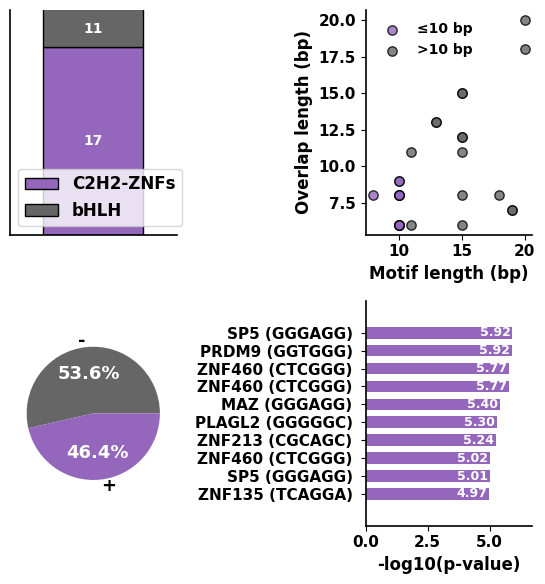

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# ---------- Global style ----------
plt.rcParams.update({
    "font.size": 12,
    "font.weight": "bold",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.2,
    "axes.labelweight": "bold",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

fig, axes = plt.subplots(2, 2, figsize=(5.6, 6))
axes = axes.ravel()

# ---------- (A) Motif hits by TF class (stacked bar, no y-axis labels) ----------
ax = axes[0]

class_counts = df['Class_clean'].value_counts()

stack_data = pd.DataFrame({
    "C2H2-ZNFs": [class_counts.get("C2H2-ZNFs", 0)],
    "bHLH": [class_counts.get("bHLH", 0)]
})

stack_data.plot(kind='bar', stacked=True, ax=ax,
                color=["#9467bd", "#666666"], edgecolor="black", width=0.6)

# Remove y-axis labels and ticks
ax.set_yticks([])
ax.set_ylabel("")

# Clean up x-axis
ax.set_xlabel("")
ax.set_xticks([])   
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(0, stack_data.values.max() * 1.2)

# Value labels inside each stacked bar
for container in ax.containers:
    ax.bar_label(container, label_type='center',
                 fontsize=10, fontweight="bold", color="white")

# ---------- (B) Scatter: overlap vs query length ----------
ax = axes[1]

# Define groups
short = df[df['Query_len'] <= 10]
long = df[df['Query_len'] > 10]

# Scatter plot with different colors
ax.scatter(short['Query_len'], short['Overlap'],
           c='#9467bd', edgecolors='black', alpha=0.8, s=45, label='≤10 bp')
ax.scatter(long['Query_len'], long['Overlap'],
           c='#666666', edgecolors='black', alpha=0.8, s=45, label='>10 bp')

# Labels
ax.set_xlabel("Motif length (bp)")
ax.set_ylabel("Overlap length (bp)")

# Legend
ax.legend(frameon=False, fontsize=10, loc='upper left')

# ---------- (C) Orientation (pie) ----------
ax = axes[2]
orient_counts = df['Orientation'].value_counts()
ax.pie(orient_counts.values,
       labels=orient_counts.index,
       autopct='%1.1f%%',
       colors=["#666666", "#9467bd"],
       textprops={'fontsize': 13, 'fontweight': 'bold'})
for t in ax.texts:
    if "%" in t.get_text():
        t.set_color("white")

# ---------- (D) Top 10 enriched motifs ----------
ax = axes[3]
human_df = df[df['Species'].astype(str).str.contains("Homo sapiens")]
top = human_df.nsmallest(10, 'p-value')[['Target_consensus', 'TF_name', 'p-value']].copy()

# Short, readable labels
labels = (
    top['TF_name'].astype(str).str.replace(r'\s+', ' ', regex=True).str.slice(0, 12)
    + " (" + top['Target_consensus'].astype(str).str[:6] + ")"
)
scores = -np.log10(top['p-value'].values)

# Make bars thinner and add extra y-margin so labels don't collide
ypos = np.arange(len(labels))
bars = ax.barh(ypos, scores, height=0.65, color='#9467bd', edgecolor='none')
ax.set_yticks(ypos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel("-log10(p-value)")

# Add space on the right so outside numbers don't hit the axes
ax.set_xlim(0, scores.max() + 0.8)
ax.margins(y=0.15)                 # extra vertical breathing room
ax.tick_params(axis='y', pad=6)    # pad ytick labels away from bars

# Place value labels smartly (inside if bar is long enough, else outside)
for i, (bar, v) in enumerate(zip(bars, scores)):
    x = bar.get_width()
    if x >= 1.4:  # threshold for "long" bar; tweak if needed
        ax.text(x - 0.08, i, f"{v:.2f}", va='center', ha='right',
                color='white', fontsize=9, fontweight='bold')
    else:
        ax.text(x + 0.08, i, f"{v:.2f}", va='center', ha='left',
                color='black', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig("/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/july_2025_mmseq/RESULT/lr3e-5_ep10/TSp_vs_genNullseqs_3k_tspAll_genNullseqs/motifs/tomtom_out_label_1/TOMTOMSTATS.svg", format="svg", dpi=1200, bbox_inches="tight")
plt.show()


In [55]:
from scipy.stats import mannwhitneyu

short = df.loc[df['Query_len'] <= 10, 'Overlap']
long = df.loc[df['Query_len'] > 10, 'Overlap']

stat, pval = mannwhitneyu(short, long, alternative="two-sided")
print(f"Mann-Whitney U = {stat}, p = {pval:.3g}")


Mann-Whitney U = 42.0, p = 0.0116


In [59]:
short

0     6
1     6
2     6
3     6
7     6
9     8
10    8
11    8
12    9
13    8
16    8
26    9
Name: Overlap, dtype: int64